In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tokenizers import Tokenizer

import pytorch_lightning as pl

from IPython.display import display
from typing import List, Dict, Any, Tuple
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from src.dataset import ApeachDataset


class ApeachStudentDataset(ApeachDataset):
    def __init__(self,
                 teacher_model: torch.nn.Module,
                 split: str,
                 teacher_tokenizer: Tokenizer, 
                 student_tokenizer: Tokenizer, 
                 max_length: int = 256,
                 padding: str = "max_length",
                 device: str="cuda") -> None:
        super().__init__(split, student_tokenizer, max_length, padding)
        
        teacher_ds = ApeachDataset(split, teacher_tokenizer, max_length, padding)

        teacher_model = teacher_model.to(device)
        with torch.no_grad():
            soft_labels = [self._get_soft_label(teacher_model, teacher_ds, i, device) 
                        for i in range(len(self))]
            self.soft_labels = torch.stack(soft_labels)

    def __getitem__(self, index: Any) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        return *super().__getitem__(index), self.soft_labels[index]

    def _get_soft_label(self, model, teacher_ds, index, device):
        ids, mask, _ = teacher_ds[index]
        ids = ids.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)
        return model(ids, mask).cpu().squeeze(0)

In [5]:
from src.lit_module import TextClassificationModule

device = 'cuda'
teacher_huggingface_model_name = 'beomi/KcELECTRA-base'
student_hgf_model_name = 'monologg/koelectra-small-v3-discriminator'
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_huggingface_model_name)
student_tokenizer = AutoTokenizer.from_pretrained(student_hgf_model_name)

curse_teacher = 'ckpt/hate_78.ckpt'
bias_teacher = 'ckpt/bias_val_epoch_loss=0.6996.ckpt'
hate_teacher = 'ckpt/hate_94_val_acc=0.7973.ckpt'
apeach_teacher = 'ckpt/hate_115_val_acc=0.8610.ckpt'
teacher_name = apeach_teacher
teacher_module = TextClassificationModule.load_from_checkpoint(teacher_name, map_location=device)
labels = teacher_module.labels
print(labels)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.ou

['hate']


In [6]:
max_length = 32

train_ds = ApeachStudentDataset(
    teacher_module, 
    "train",
    teacher_tokenizer,
    student_tokenizer,
    max_length=max_length, 
    device=device)

val_ds = ApeachStudentDataset(
    teacher_module,
    "test",
    teacher_tokenizer,
    student_tokenizer,
    max_length=max_length, 
    device=device)

del teacher_module
del teacher_tokenizer

Using custom data configuration default-1815538999999b94
Reusing dataset csv (C:\Users\heegyukim\.cache\huggingface\datasets\csv\default-1815538999999b94\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 2/2 [00:00<00:00, 181.78it/s]
Using custom data configuration default-1815538999999b94
Reusing dataset csv (C:\Users\heegyukim\.cache\huggingface\datasets\csv\default-1815538999999b94\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 2/2 [00:00<00:00, 999.83it/s]
Using custom data configuration default-1815538999999b94
Reusing dataset csv (C:\Users\heegyukim\.cache\huggingface\datasets\csv\default-1815538999999b94\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 2/2 [00:00<00:00, 999.83it/s]
Using custom data configuration default-1815538999999b94
Reusing dataset csv (C:\Users\heegyukim\.cache\huggingface\datasets\csv\default-1815538999999b94\0.0.0\433e0ccc46f9880962cc2

In [7]:
ids, mask, label, soft_label = train_ds[3]
print(ids, mask, label, soft_label, len(train_ds))

tensor([    2,    21,    16,    22,  4162, 20476,  5618, 18781,    23,    16,
           24,  4162,  6598,  4129,  6406,  4034,  9753,  6395, 10976,  4820,
         4244,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]) tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]) tensor(0.) tensor(0.0284) 7896


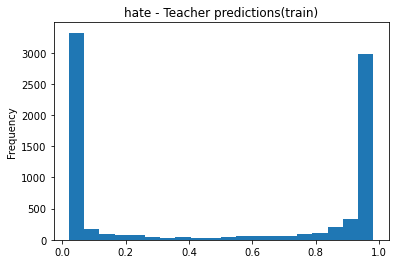

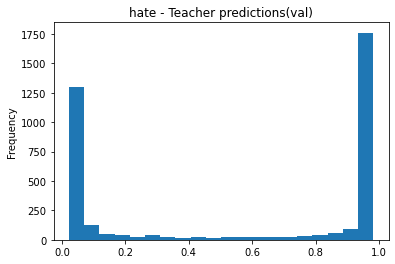

In [8]:
import matplotlib.pyplot as plt


df = pd.DataFrame(train_ds.soft_labels.numpy(), columns=labels)
for label in labels:
    df[label].plot.hist(bins=20)
    plt.title(f"{label} - Teacher predictions(train)")
    plt.show()

df = pd.DataFrame(val_ds.soft_labels.numpy(), columns=labels)
for label in labels:
    df[label].plot.hist(bins=20)
    plt.title(f"{label} - Teacher predictions(val)")
    plt.show()


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics.functional as tm
import pytorch_lightning as pl
from transformers import BertForSequenceClassification, AutoTokenizer


def join_step_outputs(outputs):
    result = {}
    keys = outputs[0].keys()
    for k in keys:
        X = [x[k] for x in outputs]
        if X[0].dim() == 0: # zero-dim tensor
            result[k] = torch.stack(X)
        else:
            result[k] = torch.cat(X, dim=0)
    return result


class TextClassificationStudentModule(pl.LightningModule):
    def __init__(self, config, labels, lr=5e-4, alpha=1.0):
        super().__init__()
        self.save_hyperparameters()
        if isinstance(config, str):
            self.model = AutoModelForSequenceClassification.from_pretrained(config, num_labels=len(labels))
        else:
            self.model = BertForSequenceClassification(config)
        self.multiclass = len(labels) > 1
        self.criterion = nn.CrossEntropyLoss() if self.multiclass else nn.BCELoss()
        self.soft_label_criterion = nn.BCELoss() # nn.KLDivLoss(reduction='batchmean')
        self.labels = labels
    
    def configure_optimizers(self):
        opt = optim.Adam(self.parameters(), lr=self.hparams.lr)
        return opt
        # sched = optim.lr_scheduler.StepLR(opt, 200, 0.5)
        # return [opt], [sched]

    def forward(self, input_ids, attention_mask=None):
        logits = self.model(input_ids, attention_mask=attention_mask).logits
        if self.multiclass:
            logits = logits.softmax(dim=-1)
        else:
            logits = logits.sigmoid().squeeze(1).float()
        return logits

    def _shared_step(self, batch):
        ids, masks, labels, soft_labels = batch
        alpha = self.hparams.alpha

        logits = self(ids, masks)
        ce_loss = self.criterion(logits, labels)
        kd_loss = self.soft_label_criterion(logits, soft_labels)
        loss = alpha * ce_loss + (1 - alpha) * kd_loss

        return {"loss": loss, "logits": logits, "labels": labels, 
                "ce_loss": ce_loss, "kd_loss": kd_loss}

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch)
    
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch)
    
    def _shared_epoch_end(self, outputs, stage):
        outputs = join_step_outputs(outputs)
        loss_names = ["loss", "ce_loss", "kd_loss"]
        for name in loss_names:
            loss = outputs[name].mean()
            self.log(f"{stage}_epoch_{name}", loss, prog_bar=True)

        logits = outputs["logits"]
        labels = outputs["labels"]
        acc = tm.accuracy(logits, labels.int())
        self.log(f"{stage}_acc", acc, prog_bar=True)
        
    def training_epoch_end(self, outputs):
        self._shared_epoch_end(outputs, "train")
        
    def validation_epoch_end(self, outputs):
        self._shared_epoch_end(outputs, "val")

In [15]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from transformers import BertConfig

batch_size = 64
alpha = 1.0

logger = pl.loggers.TensorBoardLogger(
    save_dir='.',
    name='lightning_logs'
)
save_dir = "./ckpt/"
checkpoint_callback = ModelCheckpoint(
    monitor="val_epoch_loss",
    dirpath=save_dir,
    filename=f"curse_{logger.version}",
    mode="min",
)
config = {
    "max_position_embeddings": 300,
    "hidden_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "initializer_range": 0.02, 
    "pooler_num_attention_heads": 12,
    "type_vocab_size": 2,
    "vocab_size": 30000,
    "attention_probs_dropout_prob": 0.1,
    "num_hidden_layers": 2,# 12 to 2(tiny), 4(small)
    "hidden_size": 512, # 768 to 128(tiny) 512(small)
    "num_attention_heads": 8, # 12 to 2(tiny) 8(small)
    "intermediate_size": 2048, # 3072 to 512(tiny), 2048(small)
    "num_labels": len(labels)
}
config = BertConfig(**config)
module = TextClassificationStudentModule(
    student_hgf_model_name,
    labels=labels,
    lr=5e-5,
    alpha=alpha
)
callbacks = [
    EarlyStopping("val_epoch_loss", mode="min", patience=10),
    checkpoint_callback,
    LearningRateMonitor("step")
]

trainer = pl.Trainer(max_epochs=1000, 
                logger=logger,
                gpus=1 if torch.cuda.is_available() else 0,
                val_check_interval=50,
                callbacks=callbacks)
trainer.fit(
    module,
    train_ds.dataloader(batch_size=batch_size),
    val_ds.dataloader(batch_size=batch_size))

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

D:\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


D:\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9:  12%|█▏        | 29/242 [04:41<34:28,  9.71s/it, loss=0.183, v_num=126, val_epoch_loss=0.922, val_epoch_ce_loss=0.922, val_epoch_kd_loss=0.778, val_acc=0.710, train_epoch_loss=0.189, train_epoch_ce_loss=0.189, train_epoch_kd_loss=0.424, train_acc=0.933]   

D:\Anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.save_checkpoint(f"trained_models/hate-small-best-weights-{logger.version}.ckpt", weights_only=True)